# Фильтрационный отбор признаков

---



In [54]:
# !pip install ucimlrepo

In [55]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

[UCI: Taiwanese Bankruptcy Prediction](https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction)

## Импортируем наш игрушечный набор данных

In [56]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

In [57]:
X = X.drop([' Net Income Flag'], axis=1)

In [58]:
features_names = X.columns

In [59]:
df = X.copy()
df['target'] = y.iloc[:, 0]

In [60]:
SEED = 42

In [61]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)

In [62]:
df_train.shape, df_test.shape

((5455, 95), (1364, 95))

In [63]:
y_train, y_test = df_train.target, df_test.target

In [64]:
model = LogisticRegression(random_state=SEED)

## Используем несколько фильтрационных методов отбора признаков

### Ранговая корреляция Спирмана

In [65]:
spearman_cormat = df_train.corr(method='spearman')
spearman_corvec = spearman_cormat.iloc[:-1, -1]

In [66]:
spearman_corvec

ROA(C) before interest and depreciation before interest   -0.216215
ROA(A) before interest and % after tax                    -0.218159
ROA(B) before interest and depreciation after tax         -0.217162
Operating Gross Margin                                    -0.138194
Realized Sales Gross Margin                               -0.137036
                                                             ...   
Net Income to Stockholder's Equity                        -0.221747
Liability to Equity                                        0.199479
Degree of Financial Leverage (DFL)                        -0.141224
Interest Coverage Ratio (Interest expense to EBIT)        -0.117542
Equity to Liability                                       -0.209907
Name: target, Length: 94, dtype: float64

In [67]:
# absolute_correlations

In [68]:
def FilterFitValidate(correlations, n_select):
    """
    Вспомогательная функция для фильтрации признаков по вектору корреляций
    с таргетом, обучения и валидации модели
    """
    best_filtered = correlations.abs().nlargest(n_select).index
    X_train = df_train[best_filtered]
    X_test = df_test[best_filtered]
    model_filtered = model.fit(X_train, y_train)
    y_pred = model_filtered.predict_proba(X_test)[:, 1]

    roc_auc_value = roc_auc_score(y_test, y_pred)

    return round(roc_auc_value, 2), best_filtered

In [69]:
roc_auc_value, selected_features = FilterFitValidate(spearman_corvec, 10)
print(roc_auc_value, selected_features)

0.88 Index([' Persistent EPS in the Last Four Seasons',
       ' Net Income to Total Assets', ' Net profit before tax/Paid-in capital',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Retained Earnings to Total Assets', ' Total income/Total expense',
       ' After-tax net Interest Rate', ' Continuous interest rate (after tax)',
       ' Net Income to Stockholder's Equity', ' Pre-tax net Interest Rate'],
      dtype='object')


### Взаимная информация

In [70]:
# При желании можно поиграть с матрицей взаимной информации

mi_vectors = []
for i in tqdm(df_train.columns):
  try:
    mi_vectors.append(mutual_info_classif(df_train, y=df_train[i]))
  except:
    mi_vectors.append(mutual_info_regression(df_train, y=df_train[i]))

100%|██████████| 95/95 [02:18<00:00,  1.46s/it]


In [71]:
mi_cormat = pd.DataFrame(mi_vectors, columns=df_train.columns, index=df_train.columns)
mi_corvec = mi_cormat.iloc[:-1, -1]

In [72]:
mi_corvec = pd.Series(mutual_info_classif(df_train, y=y_train)[:-1], index=features_names)

In [73]:
roc_auc_value, selected_features = FilterFitValidate(mi_corvec, 10)
print(roc_auc_value, selected_features)

0.88 Index([' Persistent EPS in the Last Four Seasons',
       ' Net Income to Stockholder's Equity',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Net Income to Total Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital', ' Interest Expense Ratio',
       ' ROA(A) before interest and % after tax',
       ' Continuous interest rate (after tax)',
       ' ROA(C) before interest and depreciation before interest'],
      dtype='object')


### ROC AUC

In [74]:
auc_corvec = pd.Series({i: roc_auc_score(y_train, df_train.loc[:, i]) for i in features_names})

In [75]:
roc_auc_value, selected_features = FilterFitValidate(auc_corvec, 10)
print(roc_auc_value, selected_features)

0.18 Index([' Total debt/Total net worth', ' Borrowing dependency', ' Debt ratio %',
       ' Liability to Equity', ' Current Liabilities/Equity',
       ' Current Liability to Equity', ' Current Liability to Current Assets',
       ' Current Liability to Assets', ' Interest-bearing debt interest rate',
       ' Equity to Long-term Liability'],
      dtype='object')


## Немного фантазии на тему избыточности информации

[немного про аггломерацию признаков](https://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html#sphx-glr-auto-examples-cluster-plot-feature-agglomeration-vs-univariate-selection-py)

In [76]:
from sklearn.cluster import AgglomerativeClustering

In [77]:
n_select = 10

In [78]:
# clustering = AgglomerativeClustering(n_select).fit(spearman_cormat)
clustering = AgglomerativeClustering(n_select).fit(mi_cormat)
clustering

AgglomerativeClustering(n_clusters=10)

In [79]:
# spearman_cormat_ = spearman_cormat.copy()
spearman_cormat_ = mi_cormat.copy()
spearman_cormat_['label'] = clustering.labels_
spearman_cormat_ = spearman_cormat_.iloc[:-1, ]

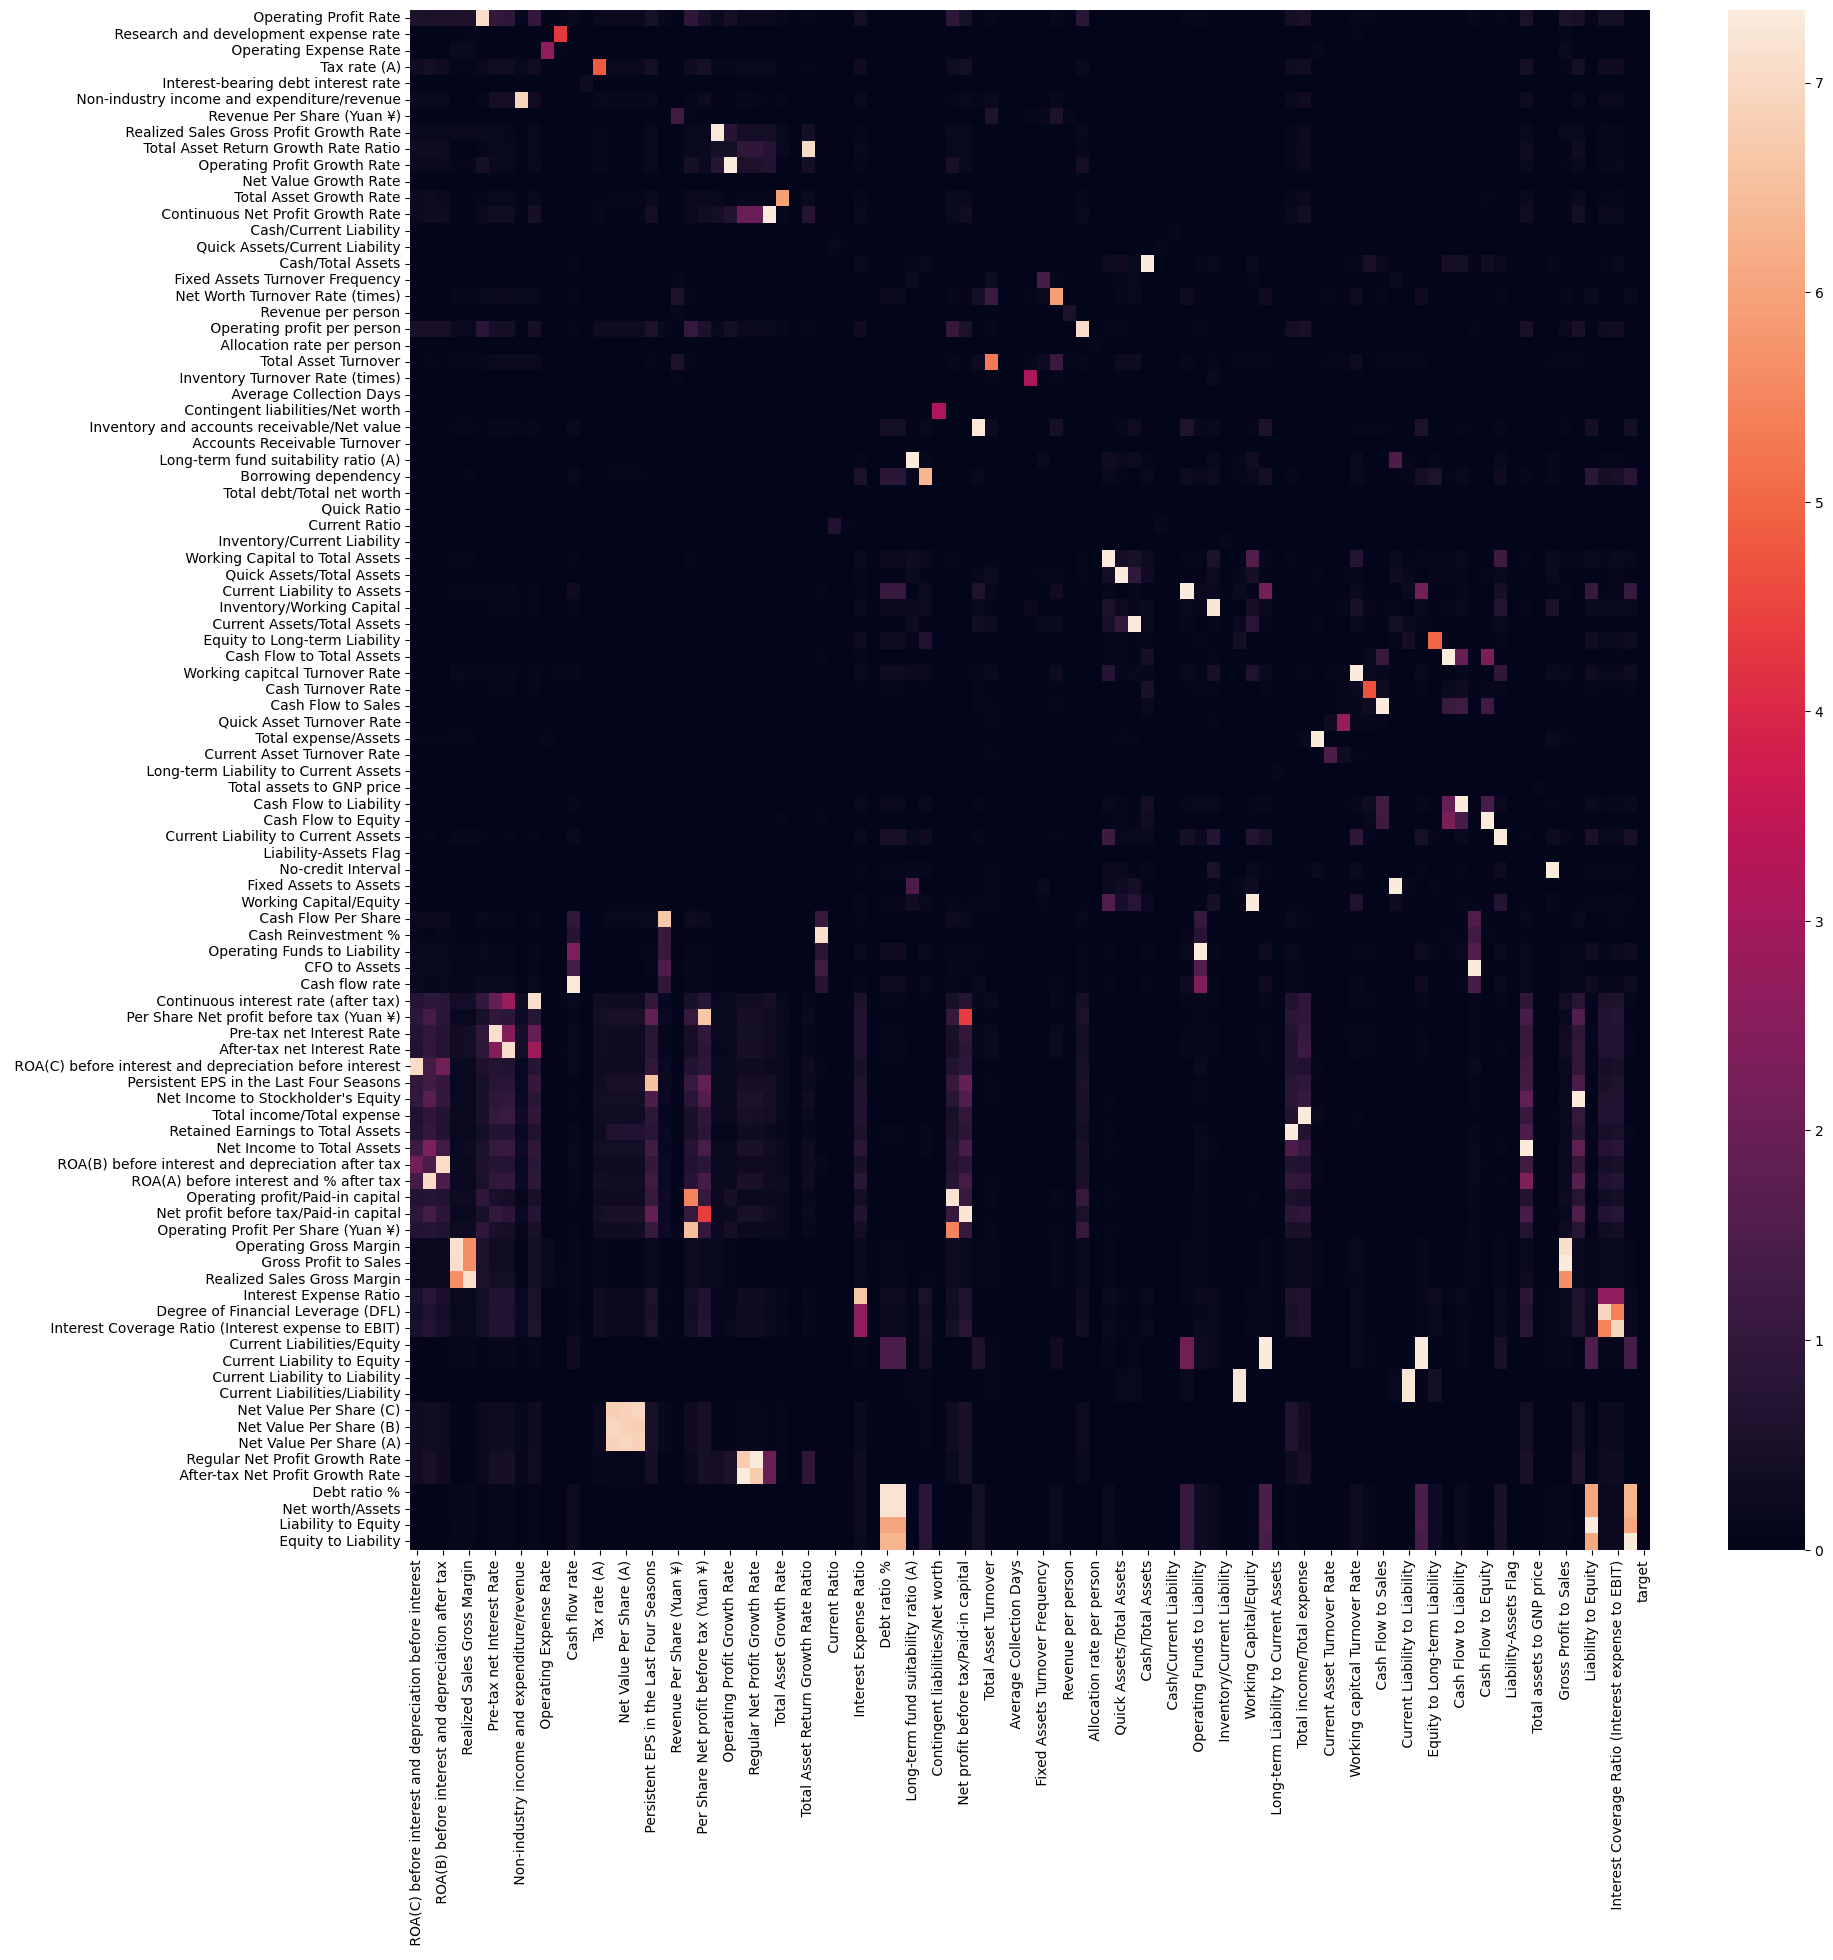

In [80]:
plt.figure(figsize=(20, 20))
sns.heatmap(spearman_cormat_.sort_values(by='label').drop('label', axis=1))
plt.show()

In [81]:
filtration_with_clustering = [
    spearman_cormat_.loc[spearman_cormat_.label.eq(i), :].target.abs().idxmax() for i in range(n_select)
    ]

In [82]:
filtration_with_clustering

[' Borrowing dependency',
 ' Operating Funds to Liability',
 ' Persistent EPS in the Last Four Seasons',
 ' Operating Gross Margin',
 ' Interest Coverage Ratio (Interest expense to EBIT)',
 ' Current Liabilities/Equity',
 ' Current Liability to Liability',
 ' Net Value Per Share (B)',
 ' After-tax Net Profit Growth Rate',
 ' Debt ratio %']

In [83]:
X_train_clust = df_train[filtration_with_clustering]
X_test_clust = df_test[filtration_with_clustering]
model_filtered = model.fit(X_train_clust, y_train)
y_pred = model_filtered.predict_proba(X_test_clust)[:, 1]

roc_auc_value = roc_auc_score(y_test, y_pred)

In [84]:
round(roc_auc_value, 2)

np.float64(0.92)

# Обёрточный отбор признаков

## Жадный прямой отбор

In [85]:
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

In [86]:
n_select = 10

In [87]:
def forward_feature_selection(learner, X_train_, y_train, X_test_, y_test, n_features_to_select=2):
    n=n_features_to_select

    best_features = []
    best_scores = []

    for i in range(1, n+1):
        scores = []
        for feature in X_train_.columns:
            selected_features = best_features.copy()
            selected_features.append(feature)
            model = learner.fit(X_train_[selected_features], y_train)
            score = roc_auc_score(y_test, model.predict_proba(X_test_[selected_features])[:, 1])
            scores.append(score)
        selected_feature = X_train_.columns[np.argmax(scores)]
        best_features.append(selected_feature)
        best_model = learner.fit(X_train_[best_features], y_train)
        best_score_ = roc_auc_score(y_test, best_model.predict_proba(X_test_[best_features])[:, 1])
        best_scores.append(best_score_)

    return best_score_, best_features

In [88]:
scores_trace = []
for i in tqdm(range(1, n_select)):
    best_score, best_features = forward_feature_selection(
        model,
        df_train.iloc[:, :-1],
        y_train,
        df_test.iloc[:, :-1],
        y_test,
        i
    )
    scores_trace.append(best_score)

100%|██████████| 9/9 [01:20<00:00,  8.95s/it]


In [89]:
best_score, best_features

(np.float64(0.9539447157385422),
 [' Persistent EPS in the Last Four Seasons',
  ' Equity to Liability',
  ' Revenue Per Share (Yuan ¥)',
  ' Cash Reinvestment %',
  ' Equity to Liability',
  ' Quick Assets/Current Liability',
  ' Revenue per person',
  ' Quick Assets/Current Liability',
  ' Interest Coverage Ratio (Interest expense to EBIT)'])

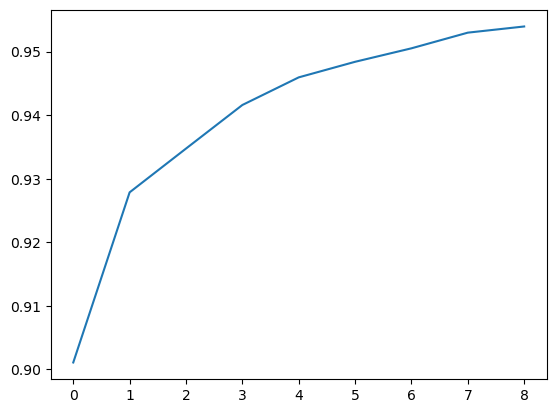

In [90]:
plt.plot(np.arange(9), scores_trace, label='Test ROC AUC')

## Неградиентная оптимизация для отбора признаков

In [91]:
# !pip install optuna

In [92]:
import optuna
from optuna.samplers import TPESampler
import warnings
# from sklearn.model_selection import RepeatedStratifiedKFold

In [93]:
def FeatureSelector(trial, df_train, df_test, random_state):

    features_series = pd.Series(
        {
            i: trial.suggest_categorical(i, [0, 1])
            for i in df_train.iloc[:, :-1].columns
        }
    )
    best_features = features_series[features_series.eq(1)].index.to_list()
    X_train, y_train = df_train[best_features], df_train.target
    X_test, y_test = df_test[best_features], df_test.target

    model = LogisticRegression(random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    roc_auc_value = roc_auc_score(y_test, y_pred)

    return round(roc_auc_value, 2)

In [94]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [95]:
random_state = SEED

### Для начала в лоб

In [96]:
sampler = TPESampler(seed=SEED)
warnings.filterwarnings("ignore")
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(
    lambda trial: FeatureSelector(
        trial,
        df_train=df_train,
        df_test=df_test,
        random_state=SEED
    ),
    n_trials=200, timeout=600, show_progress_bar=True, n_jobs=-1,
    gc_after_trial=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [97]:
study.best_trial.value

0.88

### Попробуем переписать целевую функцию


In [98]:
def FeatureSelector(trial, df_train, df_test, n_select, random_state):

    best_features = [
        trial.suggest_categorical(
            f"X{i}",
            df_train.iloc[:, :-1].columns
        ) for i in range(1, n_select+1)
    ]
    best_features = list(set(best_features))

    X_train, y_train = df_train[best_features], df_train.target
    X_test, y_test = df_test[best_features], df_test.target

    model = LogisticRegression(random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    roc_auc_value = roc_auc_score(y_test, y_pred)

    return round(roc_auc_value, 2)

In [99]:
sampler = TPESampler(seed=SEED)
warnings.filterwarnings("ignore")
study_two = optuna.create_study(direction='maximize', sampler=sampler)
study_two.optimize(
    lambda trial: FeatureSelector(
        trial,
        df_train=df_train,
        df_test=df_test,
        n_select=n_select,
        random_state=SEED
    ),
    n_trials=200, timeout=600, show_progress_bar=True, n_jobs=-1,
    gc_after_trial=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [100]:
best_features_opt = list(study_two.best_params.values())
best_features_opt

[' Interest Coverage Ratio (Interest expense to EBIT)',
 ' CFO to Assets',
 ' Continuous Net Profit Growth Rate',
 ' Net worth/Assets',
 ' Total Asset Turnover',
 ' Equity to Liability',
 ' ROA(B) before interest and depreciation after tax',
 ' Cash Flow to Equity',
 ' Non-industry income and expenditure/revenue',
 ' Current Liability to Current Assets']

# Настройка Гиперпараметров

### Пример с частичным обучением

In [101]:
from sklearn.linear_model import SGDClassifier

def objective(trial, df_train, df_test, random_state):

    X_train, y_train = df_train.iloc[:, :-1], df_train.target
    X_test, y_test = df_test.iloc[:, :-1], df_test.target
    classes = np.unique(y_train)

    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    clf = SGDClassifier(alpha=alpha, loss='log_loss', random_state=random_state)

    for step in range(100):
        clf.partial_fit(X_train, y_train, classes=classes)

        # Report intermediate objective value.
        intermediate_value = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()


    return roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

In [102]:
warnings.filterwarnings("ignore")
study_three = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(),
    direction='maximize',
    sampler=sampler
)
study_three.optimize(
    lambda trial: objective(
        trial,
        df_train=df_train[best_features_opt+['target']],
        df_test=df_test[best_features_opt+['target']],
        random_state=SEED
    ),
    n_trials=100,
    timeout=600, show_progress_bar=True, n_jobs=-1,
    gc_after_trial=False
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
study_three.best_params

{'alpha': 9.430849996296188e-05}

# Differential Evolution

In [104]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Define the Rastrigin function
def rastrigin(x):
    return 20 + (x[0]**2 - 10 * np.cos(2 * np.pi * x[0])) + (x[1]**2 - 10 * np.cos(2 * np.pi * x[1]))

# Bounds for x and y
bounds = [(-5, 5), (-5, 5)]

# Create a meshgrid for visualization
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rastrigin([X, Y])

# Set up the figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Differential Evolution Optimization on Rastrigin Function')


# Implement our own simple DE algorithm (better for teaching)


def simple_de(func, bounds, popsize=7, maxiter=10, F=0.7, CR=0.3):
    dim = len(bounds)
    pop = np.random.rand(popsize, dim)
    for i in range(popsize):
        for j in range(dim):
            pop[i,j] = bounds[j][0] + pop[i,j]*(bounds[j][1]-bounds[j][0])

    history = [pop.copy()]
    fitness = np.array([func(ind) for ind in pop])

    for gen in range(maxiter):
        for i in range(popsize):
            # Mutation
            candidates = [c for c in range(popsize) if c != i]
            a, b, c = pop[np.random.choice(candidates, 3, replace=False)]
            mutant = a + F * (b - c)

            # Crossover
            cross_points = np.random.rand(dim) < CR
            trial = np.where(cross_points, mutant, pop[i])

            # Clip to bounds
            trial = np.clip(trial, [b[0] for b in bounds], [b[1] for b in bounds])

            # Selection
            f = func(trial)
            if f < fitness[i]:
                pop[i] = trial
                fitness[i] = f

        history.append(pop.copy())
        print(f"Generation {gen+1}, best fitness: {min(fitness):.4f}")

    best_idx = np.argmin(fitness)
    return pop[best_idx], fitness[best_idx], history

# Run our simple DE
best_solution, best_fitness, population_history = simple_de(rastrigin, bounds)

print(f"Best solution: x={best_solution[0]:.4f}, y={best_solution[1]:.4f}")
print(f"Best fitness: {best_fitness:.4f}")

# Animation function
def update(frame):
    ax.clear()
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    ax.set_title(f'Generation {frame}')

    # Plot current population
    population = population_history[frame]
    for individual in population:
        ax.scatter(individual[0], individual[1], rastrigin(individual), color='red', s=50)

    # Plot best individual so far
    current_fitness = [rastrigin(ind) for ind in population]
    best_in_gen = population[np.argmin(current_fitness)]
    ax.scatter(best_in_gen[0], best_in_gen[1], rastrigin(best_in_gen),
               color='blue', s=100, marker='*')

# Create animation
ani = FuncAnimation(fig, update, frames=len(population_history), interval=500)
plt.close()

# Display animation
HTML(ani.to_jshtml())

Generation 1, best fitness: 14.9990
Generation 2, best fitness: 8.0607
Generation 3, best fitness: 8.0607
Generation 4, best fitness: 8.0607
Generation 5, best fitness: 5.3741
Generation 6, best fitness: 5.3741
Generation 7, best fitness: 5.3741
Generation 8, best fitness: 2.2621
Generation 9, best fitness: 2.2621
Generation 10, best fitness: 2.2621
Best solution: x=1.0153, y=0.9639
Best fitness: 2.2621


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Rastrigin function
def rastrigin(x):
    return 20 + (x[0]**2 - 10*np.cos(2*np.pi*x[0])) + (x[1]**2 - 10*np.cos(2*np.pi*x[1]))

# Setup
bounds = [(-5, 5), (-5, 5)]
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rastrigin([X, Y])

# Figure setup
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='f(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Differential Evolution with Convergence Path')


def differential_evolution_2d(func, bounds, popsize=15, maxiter=30, F=0.7, CR=0.3):
    global best_history
    dim = len(bounds)
    pop = np.random.rand(popsize, dim)
    for i in range(popsize):
        for j in range(dim):
            pop[i,j] = bounds[j][0] + pop[i,j]*(bounds[j][1]-bounds[j][0])

    history = [pop.copy()]
    fitness = np.array([func(ind) for ind in pop])
    best_history = [pop[np.argmin(fitness)]]

    for gen in range(maxiter):
        new_pop = pop.copy()
        for i in range(popsize):
            candidates = [c for c in range(popsize) if c != i]
            a, b, c = pop[np.random.choice(candidates, 3, replace=False)]
            mutant = a + F * (b - c)
            trial = np.where(np.random.rand(dim) < CR, mutant, pop[i])
            trial = np.clip(trial, [b[0] for b in bounds], [b[1] for b in bounds])

            if func(trial) < fitness[i]:
                new_pop[i] = trial
                fitness[i] = func(trial)

        pop = new_pop
        history.append(pop.copy())
        best_history.append(pop[np.argmin(fitness)])
        print(f"Gen {gen+1}, Best: {min(fitness):.4f} at {best_history[-1]}")

    best_idx = np.argmin(fitness)
    return pop[best_idx], fitness[best_idx], history

# Run optimization
best_solution, best_fitness, population_history = differential_evolution_2d(rastrigin, bounds)

# Animation function
def update(frame):
    ax.clear()
    ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)

    # Current population
    pop = population_history[frame]
    ax.scatter(pop[:,0], pop[:,1], color='red', s=30, alpha=0.7, label='Population')

    # Current best
    current_best = best_history[frame]
    ax.scatter(current_best[0], current_best[1], color='yellow', s=100,
               marker='*', edgecolor='black', label='Current Best')

    # Convergence path (up to current frame)
    if frame > 0:
        path = np.array(best_history[:frame+1])
        ax.plot(path[:,0], path[:,1], 'w-', linewidth=2, alpha=0.7, label='Convergence Path')
        ax.scatter(path[1:,0], path[1:,1], color='white', s=15, alpha=0.5)

    # Global optimum
    ax.scatter(0, 0, color='white', s=100, marker='P', edgecolor='black', label='Global Optimum')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Generation {frame}')
    ax.legend(loc='upper right')

# Create and display animation
ani = FuncAnimation(fig, update, frames=len(population_history), interval=500)
# Save as GIF (using Pillow writer)
# ani.save('de_optimization.gif', writer='pillow', fps=4, dpi=100)  # Adjust fps for speed

# print("GIF saved as 'de_optimization.gif'")
# plt.close()
plt.close()
HTML(ani.to_jshtml())

Gen 1, Best: 10.3908 at [-0.22534411  1.06222659]
Gen 2, Best: 10.3908 at [-0.22534411  1.06222659]
Gen 3, Best: 10.3908 at [-0.22534411  1.06222659]
Gen 4, Best: 10.3908 at [-0.22534411  1.06222659]
Gen 5, Best: 10.3732 at [-2.17798872 -0.00260061]
Gen 6, Best: 10.3732 at [-2.17798872 -0.00260061]
Gen 7, Best: 10.3732 at [-2.17798872 -0.00260061]
Gen 8, Best: 9.5538 at [0.16153482 1.13759831]
Gen 9, Best: 9.5538 at [0.16153482 1.13759831]
Gen 10, Best: 6.8390 at [ 0.16153482 -0.10448357]
Gen 11, Best: 6.8390 at [ 0.16153482 -0.10448357]
Gen 12, Best: 4.9294 at [-0.87786678  0.08362926]
Gen 13, Best: 4.4566 at [0.15552221 0.01145888]
Gen 14, Best: 4.4566 at [0.15552221 0.01145888]
Gen 15, Best: 4.4566 at [0.15552221 0.01145888]
Gen 16, Best: 2.4742 at [-0.07578334  0.08362926]
Gen 17, Best: 2.4742 at [-0.07578334  0.08362926]
Gen 18, Best: 2.4742 at [-0.07578334  0.08362926]
Gen 19, Best: 1.2264 at [ 0.00922985 -1.02787287]
Gen 20, Best: 1.2264 at [ 0.00922985 -1.02787287]
Gen 21, Best